In [1]:
%matplotlib inline


# Interpretation of coefficients in linear models


Linear models describe situations in which the target value is expected to be
a linear combination of the features (see the `linear_model` User Guide
section for a description of a set of linear model methods available in
scikit-learn).
It is important to emphasize that coefficients in multiple linear models
represent the relationship between the given feature and the target
assuming that other features remain constant.

This example will provide some hints in interpreting coefficient in linear
models, using data from the "Current Population Survey" from 1985.
We will be interested in the prediction of the wage as a function of various
features such as experience, age, or education.

A description of the dataset follows.


In [2]:
print(__doc__)

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Automatically created module for IPython interactive environment


Determinants of Wages from the 1985 Current Population Survey
-------------------------------------------------------------

### The dataset


We fetch the data from `OpenML <http://openml.org/>`_.
Note that setting the parameter `as_frame` to True will retrieve the data
as a pandas dataframe.



In [3]:
from sklearn.datasets import fetch_openml

survey = fetch_openml(data_id=534, as_frame=True)

Then, we identify features `X` and targets `y`: the column WAGE is our
target variable (i.e., the variable which we want to predict).




In [4]:
X = survey.data[survey.feature_names]
X.describe(include="all")

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


Notice that the dataset contains categorical and numerical variables.
Some of the categorical variables are binary variables.
About the numerical ones we can observe that AGE and EXPERIENCE have similar
distributions while the EDUCATION distribution is narrower.
This will give us directions on how to preprocess the data thereafter.



In [5]:
X.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


In [6]:
y = survey.target.values.ravel()
survey.target.head()

0    5.10
1    4.95
2    6.67
3    4.00
4    7.50
Name: WAGE, dtype: float64

We split the sample in a train and a test dataset.
Only the train dataset will be used in the following exploratory analysis.
This is a way to emulate a real situation where predictions are performed on
an unknown target.



In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

First, let's get some insights by looking at the variable distributions and
at the pairwise relationships between them. Only numerical
variables will be used.



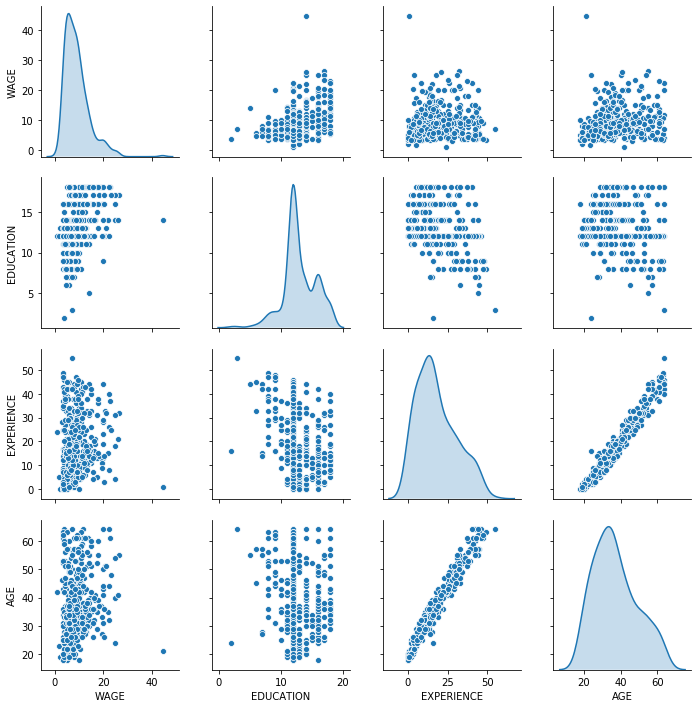

In [8]:
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
sns.pairplot(train_dataset, diag_kind='kde')

Looking closely at the WAGE distribution it could be noticed that it has a
long tail and we could take its logarithm
to simplify our problem and approximate a normal distribution.
The WAGE is increasing when EDUCATION is increasing.
Also, the EXPERIENCE and AGE are linearly correlated.


### The pipeline


To design our machine-learning pipeline, we manually
check the type of data that we are dealing with:



In [9]:
survey.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 10 columns):
EDUCATION     534 non-null float64
SOUTH         534 non-null category
SEX           534 non-null category
EXPERIENCE    534 non-null float64
UNION         534 non-null category
AGE           534 non-null float64
RACE          534 non-null category
OCCUPATION    534 non-null category
SECTOR        534 non-null category
MARR          534 non-null category
dtypes: category(7), float64(3)
memory usage: 17.1 KB


As seen previously, the dataset contains columns with different data types
and we need to apply a specific preprocessing for each data types.
In particular categorical variables cannot be included in linear model if not
coded as integers first. In addition, to avoid categorical features to be
treated as ordered values, we need to one-hot-encode them.
Our pre-processor will

- one-hot encode (i.e., generate a column by category) the categorical
  columns;
- replace by 0 and 1 the categories of binary columns;
- as a first approach (we will see after how the normalisation of numerical
  values will affect our discussion), keep numerical values as they are.



In [10]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

categorical_columns = ['RACE', 'OCCUPATION', 'SECTOR']
binary_columns = ['MARR', 'UNION', 'SEX', 'SOUTH']
numerical_columns = ['EDUCATION', 'EXPERIENCE', 'AGE']

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    remainder='passthrough'
)

#### Linear Regression from scikit-learn

(0, 27)

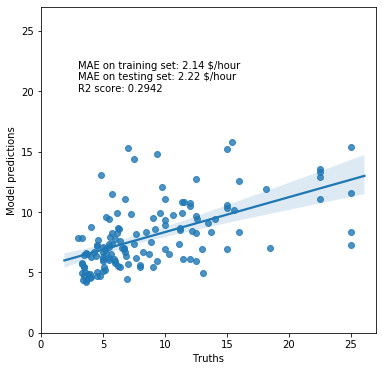

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)
model.fit(X_train, y_train)

from sklearn.metrics import median_absolute_error

y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = 'MAE on training set: {0:.2f} $/hour'.format(mae)
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
r2score = model.score(X_test, y_test)

string_score += '\nMAE on testing set: {0:.2f} $/hour'.format(mae)
string_score += '\nR2 score: {0:.4f}'.format(r2score)
fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(y_test, y_pred)

plt.text(3, 20, string_score)

plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 27])
plt.ylim([0, 27])

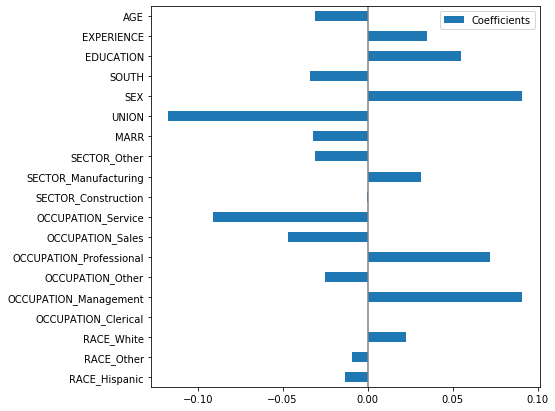

In [12]:
feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.concatenate(
    [feature_names, binary_columns, numerical_columns])

coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

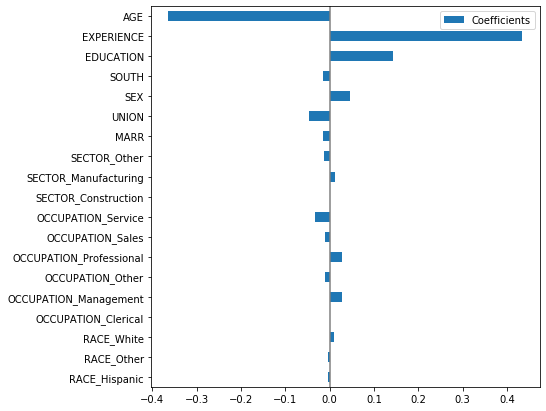

In [13]:
X_train_preprocessed = pd.DataFrame(
    model.named_steps['columntransformer'].transform(X_train),
    columns=feature_names
)
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_ *
    X_train_preprocessed.std(axis=0),
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

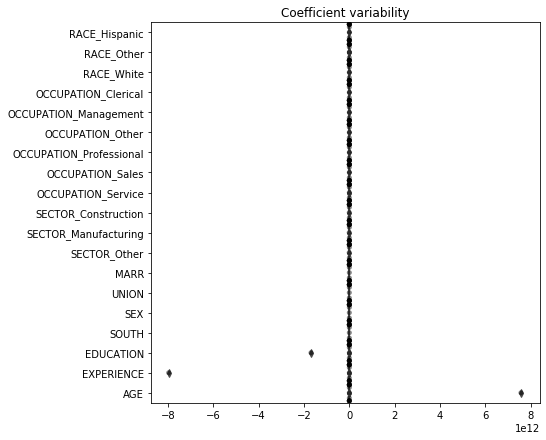

In [25]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=3),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.std(axis=0)
     for est in cv_model['estimator']],
    columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title('Coefficient variability')
plt.subplots_adjust(left=.3)

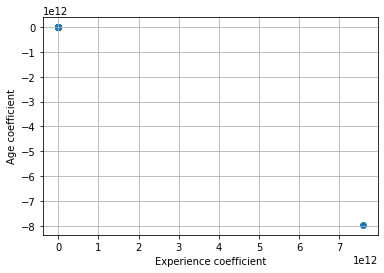

In [26]:
plt.ylabel('Age coefficient')
plt.xlabel('Experience coefficient')
plt.grid(True)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])

#### Linear Regression from StatsModel

In [32]:
import statsmodels.api as sm

results = sm.OLS(np.asarray(y_train), np.asarray(X_train_preprocessed)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     10.62
Date:                Thu, 19 Dec 2019   Prob (F-statistic):           1.77e-22
Time:                        12:10:40   Log-Likelihood:                -1144.8
No. Observations:                 400   AIC:                             2324.
Df Residuals:                     383   BIC:                             2392.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8782      2.817      0.312      0.755      -4.660       6.416
x2             0.8489      2.776      0.306      0.760      -4.609       6.307
x3             1.6424      2.743      0.599      0.550      -3.750       7.035
x4            -0.0753      1.460     -0.052      0.959      -2.946       2.796
x5             3.0324      1.536      1.974      0.049       0.012       6.053
x6            -0.0444      1.398     -0.032      0.975      -2.794       2.705
x7             1.8372      1.477      1.244      0.214      -1.068       4.742
x8            -0.4615      1.574     -0.293      0.770      -3.557       2.634
x9            -0.9189      1.447     -0.635      0.526      -3.765       1.927
x10            0.9069      2.837      0.320      0.749      -4.670       6.484
x11            1.8333      2.778      0.660      0.510      -3.628       7.295
x12            0.6294      2.734      0.230      0.818      -4.746       6.005
x13           -0.3360      0.482     -0.697      0.487      -1.284       0.612
x14           -2.1914      0.598     -3.667      0.000      -3.366      -1.016
x15            1.8806      0.496      3.792      0.000       0.905       2.856
x16           -0.4765      0.500     -0.954      0.341      -1.459       0.506
x17            0.8416      1.104      0.763      0.446      -1.328       3.012
x18            0.3687      1.097      0.336      0.737      -1.788       2.525
x19           -0.2804      1.096     -0.256      0.798      -2.435       1.874
==============================================================================
Omnibus:                      222.050   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2876.334
Skew:                           2.062   Prob(JB):                         0.00
Kurtosis:                      15.473   Cond. No.                     7.99e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.33e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### RidgeCV
To describe the dataset as a linear model we choose to use a ridge regressor
and to model the logarithm of the WAGE.
We sample the complexity parameter space between 1.e-10 and 1.e10.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=np.logspace(-10, 10, 21)),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)

Processing the dataset
......................

First, we fit the model and we verify which value of $\alpha$ has been
selected.



In [ ]:
model.fit(X_train, y_train)
model[-1].regressor_.alpha_

Once verified that the $\alpha$ parameter is not at the boundary of
the sampled parameter space, we can check the performance of the computed
model using, for example, the median absolute error of the model and the R
squared coefficient.



In [ ]:
from sklearn.metrics import median_absolute_error

y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = 'MAE on training set: {0:.2f} $/hour'.format(mae)
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
r2score = model.score(X_test, y_test)

string_score += '\nMAE on testing set: {0:.2f} $/hour'.format(mae)
string_score += '\nR2 score: {0:.4f}'.format(r2score)
fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(y_test, y_pred)

plt.text(3, 20, string_score)

plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 27])
plt.ylim([0, 27])

The model learnt is far from being a good model making accurate predictions:
the R squared score is very low.
As interpretation tools characterize model rather than the generative process
of the data itself, it needs to be emphasized that interpretations are
correct if the model is correct as well.
In this case, we are more interested in providing a methodology than in
having a good description of the data: a bad example could illustrate the
importance of cross checking the results.

Interpreting coefficients
.........................

First of all, we can plot the values of the coefficients of the regressor we
have fitted.



In [ ]:
feature_names = (model.named_steps['columntransformer']
                      .named_transformers_['onehotencoder']
                      .get_feature_names(input_features=categorical_columns))
feature_names = np.concatenate(
    [feature_names, binary_columns, numerical_columns])

coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Soon we realize that we cannot compare different coefficients since we did
not scale the data before the fit, features having different value ranges.
For instance, the AGE coefficient is expressed in $/hours/leaving years
while the EDUCATION is expressed in $/hours/years of education.
This is evident if we compare feature standard deviations.



In [ ]:
X_train_preprocessed = pd.DataFrame(
    model.named_steps['columntransformer'].transform(X_train),
    columns=feature_names
)
X_train_preprocessed.std(axis=0).plot(kind='barh', figsize=(9, 7))
plt.title('Features std. dev.')
plt.subplots_adjust(left=.3)

We should then scale the coefficients by the standard deviation and we
will be able to better compare them: indeed, the greater the
variance of a feature, the larger the impact of the corresponding coefficent
on the output, all else being equal.



In [ ]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_ *
    X_train_preprocessed.std(axis=0),
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

The plot above tells us that an increase of the AGE will induce a decrease
of the WAGE when all other features remain constant, for instance at a
constant EXPERIENCE. An increase of the EXPERIENCE will induce an increase
of the WAGE when all other features remain constant.

Checking the coefficient variability
....................................

We can check the coefficient variability through cross-validation.
If coefficients vary in a significant way changing the input dataset
the robustness of the model is not guaranteed.



In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.std(axis=0)
     for est in cv_model['estimator']],
    columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title('Coefficient variability')
plt.subplots_adjust(left=.3)

The AGE and EXPERIENCE coefficients are affected by strong variability which
might be due to the collinearity between the 2 features.
To verify this interpretation we plot the variability of the AGE and
EXPERIENCE coefficient:



In [ ]:
plt.ylabel('Age coefficient')
plt.xlabel('Experience coefficient')
plt.grid(True)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])

Two regions are populated: when the EXPERIENCE coefficient is
positive the AGE one is in general negative and viceversa, except for a small
number of positive points around zero.

To go further we remove one of the 2 features and check what is the impact
on the model stability.



In [ ]:
column_to_drop = ['AGE']

cv_model = cross_validate(
    model, X.drop(columns=column_to_drop), y,
    cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_ *
     X_train_preprocessed.drop(columns=column_to_drop).std(axis=0)
     for est in cv_model['estimator']],
    columns=feature_names[:-1]
)
plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title('Coefficient variability')
plt.subplots_adjust(left=.3)

The estimation of the EXPERIENCE coefficient is now less variable and
remain important for all predictors trained during cross-validation.

Preprocessing numerical variables
.................................

As said above (see "`the-pipeline`"), we could also choose to scale
numerical values before training the model.
In the following we will check how this approach will modify the analysis on
coefficient variability and interpretation.
The preprocessor is redefined in order to subtract the mean and scale
variables to unit variance.



In [ ]:
from sklearn.preprocessing import StandardScaler

preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (OrdinalEncoder(), binary_columns),
    (StandardScaler(), numerical_columns),
    remainder='passthrough'
)

The model will stay unchanged.



In [ ]:
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=np.logspace(-10, 10, 21)),
        func=np.log10,
        inverse_func=sp.special.exp10
    )
)

model.fit(X_train, y_train)
model[-1].regressor_.alpha_

Again, we check the performance of the computed
model using, for example, the median absolute error of the model and the R
squared coefficient.



In [ ]:
y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = 'MAE on training set: {0:.2f} $/hour'.format(mae)
y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
r2score = model.score(X_test, y_test)

string_score += '\nMAE on testing set: {0:.2f} $/hour'.format(mae)
string_score += '\nR2 score: {0:.4f}'.format(r2score)
fig, ax = plt.subplots(figsize=(6, 6))
sns.regplot(y_test, y_pred)

plt.text(3, 20, string_score)

plt.ylabel('Model predictions')
plt.xlabel('Truths')
plt.xlim([0, 27])
plt.ylim([0, 27])

The R squared coefficient is not better than for the non-normalized case.
For the coefficient analysis, scaling is not needed this time.



In [ ]:
coefs = pd.DataFrame(
    model.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['Coefficients'], index=feature_names
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

We cross validate the coefficients.



In [ ]:
cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)
coefs = pd.DataFrame(
    [est.named_steps['transformedtargetregressor'].regressor_.coef_
     for est in cv_model['estimator']],
    columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title('Coefficient variability')
plt.subplots_adjust(left=.3)

The result is significantly different.
AGE and EXPERIENCE coefficients are less variable than other coefficients,
they are both positive.



In [ ]:
plt.ylabel('Age coefficient')
plt.xlabel('Experience coefficient')
plt.grid(True)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])

Even if the model is still not able to provide a good description of the
dataset, the normalization of numerical features clearly provides more
reliable results for the coefficients.

